In [219]:
# Importamos las librerias necesarias
import torch
import torchvision
import torch.nn as nn
import os
import glob as gb
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random 
from skimage import io
from PIL import Image
from skimage import io
from skimage.transform import resize

# Verificaremos si tenemos GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [220]:
# Descargamos dataset
PATH = '/content/drive/MyDrive/DCGANs bolsas'

classes = os.listdir(PATH)
classes

['detergentes', 'nylon', 'galletas']

In [221]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: detergentes. Imágenes: 100
Categoría: nylon. Imágenes: 359
Categoría: galletas. Imágenes: 560


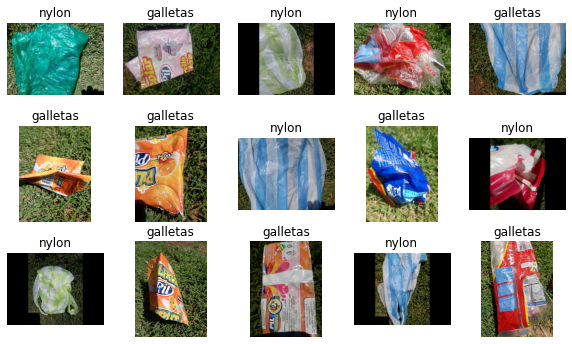

In [222]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [223]:
#  Convertimos las imgenes a escala de grises
# imgsGray = []
# for i in imgs:
#   image = Image.open(i)
#   imgsGray.append(np.array(image.convert('L')))
  # print(imgsGray[0])

In [224]:
#  Convertimos las imgenes a escala de grises y redimensionamos
imgsGray = []
for i in imgs:
  image = Image.open(i)
  convert = np.array(image.convert('L'))
  imgsGray.append(resize(convert,(28,28)))
  # print(imgsGray[0])
  # print(i)

In [225]:
imgsGray[1000].shape  # Dimensione de una de las imagenes

(28, 28)

In [226]:
# Descargamos dataset
from sklearn.model_selection import train_test_split

# train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgsGray, labels, test_size=0.2, stratify=labels)
train_imgs = imgsGray

len(train_imgs) # Longitud o numero total de imgenes para entrenar

1019

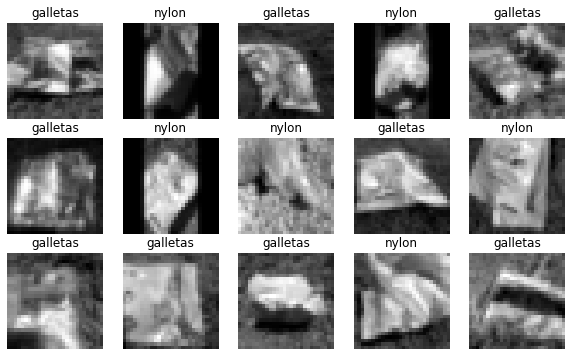

In [227]:
# Visualizando algunos imagenes del dataset redimensionadas in Gray
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(train_imgs)-1)
    img = train_imgs[ix]
    ax.imshow(img, cmap=plt.cm.gray)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [228]:
# img = train_imgs[100]
# img.shape
# im = plt.imread('filename.jpeg')
# im = train_imgs[100]
# res = resize(im, (140, 54))
# res.shape

In [229]:
# Creamos la clase dataset de basuras de plastico

class Dataset(torch.utils.data.Dataset):
  def __init__(self, trainset, trans):
    self.imgs = torch.tensor([np.array(i).flatten() / 255. for i in trainset], dtype=torch.float, device=device)
    self.imgs = self.imgs * 2. - 1.
    self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)
    self.trans = trans

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ix):
    return self.imgs[ix], self.labels[ix]
    # cargar la imágen
    img = io.imread(self.imgs[ix])
    # aplicar transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])


In [230]:
import albumentations as A

trans = A.Compose([
    A.Resize(28, 28)
])

train =  Dataset(train_imgs,trans) 

len(train)

1019

In [231]:
# Dimensiones, tipos, maximo, minimo
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([784]), torch.float32, tensor(-0.9933), tensor(-1.))

In [232]:
# Cramos el dataloader con batchsize, mezclar aleatoriamenre
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 784]), torch.Size([32, 28]))



---



In [233]:
# Funcion de entrenamiento
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=200, crit=None):
  g.to(device)
  d.to(device)
  g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
  d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
  crit = nn.BCEWithLogitsLoss() if crit == None else crit
  g_loss, d_loss = [], []
  mb = master_bar(range(1, epochs+1))
  hist = {'g_loss': [], 'd_loss': []}
  for epoch in mb:
    for X, y in progress_bar(dataloader, parent=mb):
      #X, y = X.to(device), y.to(device)  
      # entrenamos el discriminador
      g.eval()
      d.train()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   input del discrminator
      d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
      #   gorund truth para el discriminator
      d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
      #   optimización
      d_optimizer.zero_grad()
      d_output = d(d_input)
      d_l = crit(d_output, d_gt)
      d_l.backward()
      d_optimizer.step()
      d_loss.append(d_l.item())
      # entrenamos el generador
      g.train()
      d.eval()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   salidas del discriminador
      d_output = d(genenerated_images)
      #   ground truth para el generator
      g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
      #   optimización
      g_optimizer.zero_grad()
      g_l = crit(d_output, g_gt)
      g_l.backward()
      g_optimizer.step()
      g_loss.append(g_l.item())
      # logs
      mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
    mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
    hist['g_loss'].append(np.mean(g_loss))    
    hist['d_loss'].append(np.mean(d_loss))
  return hist

In [234]:
# Creamos la red neuronal Convolucional para el Generador
# Se usa la traspuesta de la convolucion para generar
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_size = 100
    self.inp = nn.Sequential(
        nn.Linear(self.input_size, 7*7*128),
        nn.BatchNorm1d(7*7*128),
    )
    self.main = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.inp(x)
    x = x.view(-1, 128, 7, 7)
    x = self.main(x)
    x = x.view(x.size(0), 28*28)
    return x

In [235]:
# Creamos la clase red neuronal Convolucional Discriminador
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )
    self.out = nn.Sequential(
        nn.Linear(128*7*7, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    # esperamos vectores a la entrada de 28*28
    x = x.view(x.size(0), 1, 28, 28)
    x = self.main(x)
    x = x.view(x.size(0), -1)
    x = self.out(x)
    return x

In [236]:
# Intanciar el Generador
generator = Generator()
output = generator(torch.randn(64, 100))
output.shape

torch.Size([64, 784])

In [237]:
# Dimensiones, tipos, maximo, minimo
# img, label = train[0]
# img.shape, img.dtype, img.max(), img.min()



---



In [238]:
# Instanciamos el Discriminador
discriminator = Discriminator()
output = discriminator(torch.randn(64, 28*28))
output.shape

torch.Size([64, 1])

In [239]:
# Entrenamos el modelo
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss())

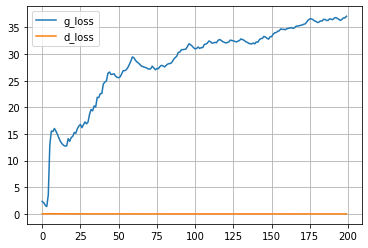

In [243]:
# Graficamos las curvas de entrenamiento
import pandas as pd 

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

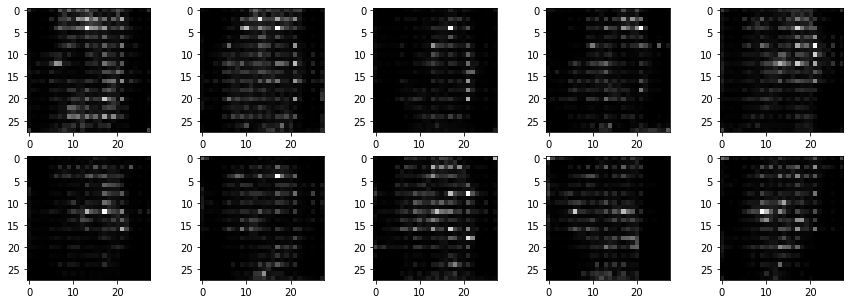

In [244]:
# Probamos en modelo y vemos lo que genera
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(28,28).cpu()
      _ax.imshow(img, cmap=plt.cm.gray)
      i+=1
  plt.show()